In [1]:
import numpy as np
import json 
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
songs = sc.textFile("s3n://stat-37601/new-songs.mp3.base64.json",minPartitions = 100).map(json.loads)

In [3]:
# create a small sample of songs so that it doesn't take as long
seed = random.randint(0,10000)
#small_songs = songs.sample(False, 0.5, seed)
small_songs = songs
print("The number of samples is %d." %small_songs.count())

The number of samples is 5627.


Part (a) Processing Songs

In [4]:
import base64
from io import BytesIO
import numpy as np
from pydub import AudioSegment

# convert a song data into samples in [-1, 1]
def audio_segment_to_samples(base64d_mp3d_song_data):
    mp3_buffer = BytesIO(base64.b64decode(base64d_mp3d_song_data))
    audio = AudioSegment.from_mp3(mp3_buffer)
    wave = audio.export('/tmp/buffer.wav', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

In [5]:
# Jeremy's function to play the song - takes in the data in original format
def audio_segment_in_ipython(song_data):
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px" >
        <source controls
            src="data:audio/mp3;base64,{}" type="audio/mp3" />
      </audio>""".format(song_data)))

In [6]:
# example of playing song
first = small_songs.first()
audio_segment_in_ipython(first['data'])

In [7]:
songs_samples = small_songs.map(lambda x: (x['song_id'], audio_segment_to_samples(x['data'])))
songs_samples.first()

(0, array([  0.00000000e+00,   0.00000000e+00,  -3.05175781e-05, ...,
         -8.85009766e-04,  -1.22070312e-04,  -4.88281250e-04]))

Convert each sample into a spectrogram

In [8]:
import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter
# convert samples into a spectrogram and return peaks
def find_peaks(samples):
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
    # Don’t rescale by 1/f!
    maxes = (maximum_filter(ft_graph, size=20) == ft_graph) & \
    (ft_graph > -150)
    # Compute relative maxima 20 units away from others, where
    # intensity is greater than -150 dB.
    freqs, times = np.where(maxes)
    # Sort by time instead of frequency
    times, freqs = (list(t) for t in zip(*sorted(zip(times, freqs))))
    return (freqs, times)

songs_peaks = songs_samples.map(lambda x: (x[0], find_peaks(x[1])))
num_peaks = songs_peaks.map(lambda x: (x[0], len(x[1][0])))
num_peaks = num_peaks.reduceByKey(lambda a, b : a+b)

Plot of the number of fingerprints (peaks) for each song

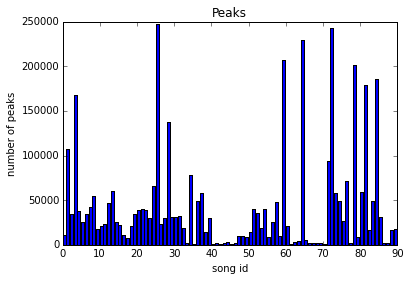

In [9]:
num_peaks_pairs = num_peaks.collect()
xs = [x[0] for x in num_peaks_pairs]
ys = [x[1] for x in num_peaks_pairs]
plt.bar(xs, ys)
plt.ylabel('number of peaks')
plt.xlabel('song id')
plt.title('Peaks')

In [10]:
num_peaks = num_peaks.map(lambda x: x[1])
# number of songs
num_songs = num_peaks.count()
print("The number of songs is %d." %num_songs)

The number of songs is 90.


In [11]:
# average number of peaks 
tot = num_peaks.reduce(lambda a, b: a+b)
print("The average number of peaks is %.2f." %(tot/float(num_songs)))

The average number of peaks is 43132.49.


Part (b) Hashing

In [12]:
import hashlib
def hash_two_close_peaks(time1, freq1, time2, freq2, reduction=0):
    return hashlib.sha1("{}:{}:{}".format(time2 - time1, freq2, freq1)).hexdigest()[:(40-reduction)]

In [13]:
#print hash_two_close_peaks(0, 62, 0, 72, reduction=10)
#print hash_two_close_peaks(0, 62, 0, 72)

In [14]:
# function to iterate through the array of times and array of frequencies
def hash_peaks(labeled_peaks, reductions):
    peaks = labeled_peaks[1]
    times = peaks[0]
    freqs = peaks[1]
    hashes = []
    # not sure if this is the right way to identify peaks <200 frames apart
    for i in range(len(times)-1):
        if times[i+1] - times[i] < 200:
            peak_hash = hash_two_close_peaks(times[i], freqs[i], times[i+1], freqs[i+1], reductions)
            hashes.append(peak_hash)
    return labeled_peaks[0], hashes

In [15]:
hashes = songs_peaks.map(lambda x: hash_peaks(x, 0))         

In [16]:
def label_hashes(h):
    hs = []
    label = h[0]
    hashes = h[1]
    for x in hashes:
        pair = (label, x)
        hs.append(pair)
    return hs
labeled_hashes = hashes.map(label_hashes)
#labeled_hashes.first()

In [17]:
parallel_hashes = labeled_hashes.flatMap(lambda x: x)

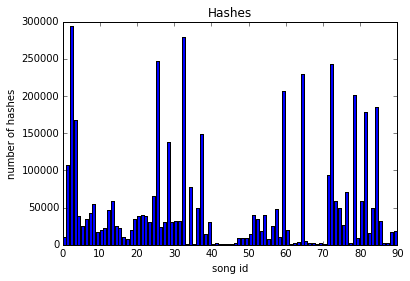

In [18]:
# number of hashes for each song
num_hashes = parallel_hashes.map(lambda x: (x[0], 1))
num_hashes = num_hashes.reduceByKey(lambda a, b: a+b)
num_hashes = num_hashes.collect()
xs = [x[0] for x in num_hashes]
ys = [x[1] for x in num_hashes]
plt.bar(xs, ys)
plt.ylabel('number of hashes')
plt.xlabel('song id')
plt.title('Hashes')

The number of hashes for each song varies but can be very high. By the graph we can see some hashes have around 250,000 hashes. Thus, we can imagine that trying to store hashes for a great number of songs would require a lot of memory. <br>
The reduction parameter changes the number of digits in the hash. Reducing by 10 would create a hash of length 30. This would save on storage space, but would create more collisions and thus less clarity about the uniqueness of songs or song similarities.<br>
We initially combined the hashes for all songs using a reduce function before parallelizing the hashes again. However, this process took too long so we used flatMap instead to achieve the same effect. We used the full 40 digits of the hashes because our code ran in a reasonable amount of time (within a few minutes). 

Part (c) Common Peaks

In [19]:
#Switch song ID and hash order
parallel_hashes2 = parallel_hashes.map(lambda x: (x[1], x[0]))
#Group song ID by hashes
hash_groups = parallel_hashes2.groupByKey().map(lambda(x): (x[0], list(set(list(x[1])))))

#Generate pairs of list of song IDS for each hash
def pair(x):
    h=x[0]
    ids=x[1]
    pairs = []
    for i in range(len(ids)):
        pairs.append([h,(ids[i],ids[i])])
        pairs.append([h,(ids[i],ids[i])]) #append twice to keep relative values correct
        for j in range(i+1,len(ids)):
            pairs.append([h,(ids[i],ids[j])])
            pairs.append([h,(ids[j],ids[i])]) #append twice to keep symmetry in pairs
    return pairs

hash_pairs = hash_groups.flatMap(pair)
#Find number of hashes shared by each pair
num_hashes_shared = hash_pairs.map(lambda x: (x[1], len(x[0]))).reduceByKey(lambda a,b: a+b)
nc_dict = dict(num_hashes_shared.collect())

Plot pairwise distance matrix over all songs

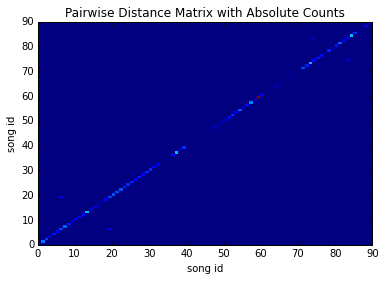

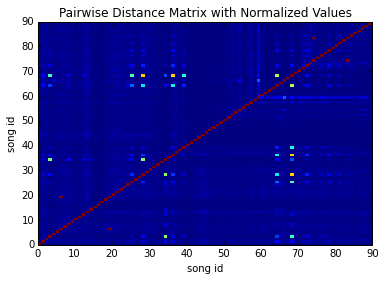

In [20]:
n = num_songs

#put into array
a = [[0.0 for y in range(n)] for x in range(n)]
for i in range(n):
    for j in range(n):
        a[i][j] = float(nc_dict.get((i,j),0))
a = np.asarray(a)
plt.pcolor(a)
plt.ylabel('song id')
plt.xlabel('song id')
plt.title('Pairwise Distance Matrix with Absolute Counts')
plt.show()

# Normalize and plot
for i in range(n):
    for j in range(n):
        a[i][j] = (2*a[i][j])/float(a[i][i]+a[j][j])


plt.pcolor(a, vmin=0, vmax=1.0)
plt.ylabel('song id')
plt.xlabel('song id')
plt.title('Pairwise Distance Matrix with Normalized Values')
plt.show()

To normalize the distances, we divided the number of peaks shared by each pair by the sum of the number of peaks in both songs and multiplied by 2 so that the max normalized value is 1.0. The result is that the normalized value for every pair of a song and itself was the same, i.e. 1.0. For all other pairs, the normalized value is the relative count of the number of peaks with respect to how many peaks the songs in the pair had. 

In [21]:
x,y = np.where(a>0.9)
duplicates = []
for (xi,yi) in zip(x,y):
    if xi != yi and (yi,xi) not in duplicates:
        duplicates.append((xi,yi))
        
for i, p in enumerate(duplicates):
    value = a[p[0]][p[1]]
    duplicates[i] = (p, value)
print duplicates

[((6, 19), 0.99999963562176231), ((74, 83), 0.99999945067048412)]


There are several duplicated songs in the dataset. Which are they? How “similar” do they appear to be?  
The duplicated songs were identified for songs that had a normalized value > 0.9. The above list gives the song ID of duplicates along with their normalized value, i.e. songs 6 and 19 are duplicates and songs 74 and 83 are duplicates. Both of these pairs of duplicates are nearly identical, with normalized similarity values close to 1.